In [2]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import glob
import pickle
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100


CURR_DIR = os.getcwd()

In [3]:
# necessary definitions

MAIN_DIR = os.path.join(CURR_DIR,"..","..")
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
os.makedirs(FIG_DIR,exist_ok=True)

SPEAKER = ["RL","RN","SR","US"]
MODE = ["mentally","mouthed"]
WORDS = ["add","call","go","later","left","reply","right","stop","subtract","you"]

# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## IMPORTING DATASET

In [4]:
all_files = glob.glob(DATA_DIR+"/**/*.txt",recursive=True)
print(len(all_files))

143


In [5]:
def parser(files):
    dataset = {"data":[], "speaker":[], "mode":[], "word":[]}
    def get_data(file):
        word = file.split("/")[-2]
        mode = file.split("/")[-3]
        speaker = file.split("/")[-4]
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    signal.append(frames[indices[len(indices)-2]:indices[len(indices)-1],:-1])   
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["mode"].extend([mode]*len(signal))
        dataset["word"].extend([word]*len(signal))
        
    for file,i in zip(files,tqdm.tqdm(range(len(files)),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

In [6]:
if("dataset.pickle" in os.listdir(DATA_DIR)):
    file = open(os.path.join(DATA_DIR,"dataset.pickle"),"rb")
    all_data = pickle.load(file)
else:
    all_data = parser(all_files)
    pickle.dump(all_data,open(os.path.join(DATA_DIR,"dataset.pickle"),"wb"))
    
print(type(all_data))
print(all_data.keys())
print(len(all_data["data"]))
# print(len(all_data["speaker"]))
# print(len(all_data["mode"]))
# print(len(all_data["word"]))

<class 'dict'>
dict_keys(['data', 'speaker', 'mode', 'word'])
5760


In [7]:
df = pd.DataFrame(all_data)

In [8]:
df.head(10)

,data,speaker,mode,word
0,"[[-5164.75048828125, 13814.2490234375, 20503.0...",US,mentally,call
1,"[[-4489.951171875, 14413.25390625, 21136.00976...",US,mentally,call
2,"[[-4912.06396484375, 13982.021484375, 20753.37...",US,mentally,call
3,"[[-5024.11328125, 13876.38671875, 20612.509765...",US,mentally,call
4,"[[-4539.9521484375, 14349.4619140625, 21077.82...",US,mentally,call
5,"[[-4614.6513671875, 14220.1572265625, 20885.62...",US,mentally,call
6,"[[-4235.07421875, 14610.10546875, 21225.328125...",US,mentally,call
7,"[[-4462.1455078125, 14519.71484375, 21020.6074...",US,mentally,call
8,"[[-5077.8916015625, 13973.7734375, 20512.95507...",US,mentally,call
9,"[[-4274.48046875, 14754.20703125, 21222.376953...",US,mentally,call


In [9]:
df.tail(10)

,data,speaker,mode,word
5750,"[[42733.96484375, 36400.70703125, 30241.707031...",SR,mouthed,right
5751,"[[43283.1015625, 37179.5546875, 30818.96484375...",SR,mouthed,right
5752,"[[43214.99609375, 36870.72265625, 30721.824218...",SR,mouthed,right
5753,"[[43307.80078125, 37025.7734375, 30925.6269531...",SR,mouthed,right
5754,"[[42967.31640625, 36828.140625, 30559.14648437...",SR,mouthed,right
5755,"[[43039.37890625, 37023.94140625, 30637.222656...",SR,mouthed,right
5756,"[[42744.04296875, 37074.546875, 30351.8359375,...",SR,mouthed,right
5757,"[[42961.2578125, 37337.08984375, 30556.5332031...",SR,mouthed,right
5758,"[[43036.11328125, 37416.4609375, 30671.5546875...",SR,mouthed,right
5759,"[[43227.53515625, 37926.23828125, 30925.939453...",SR,mouthed,right


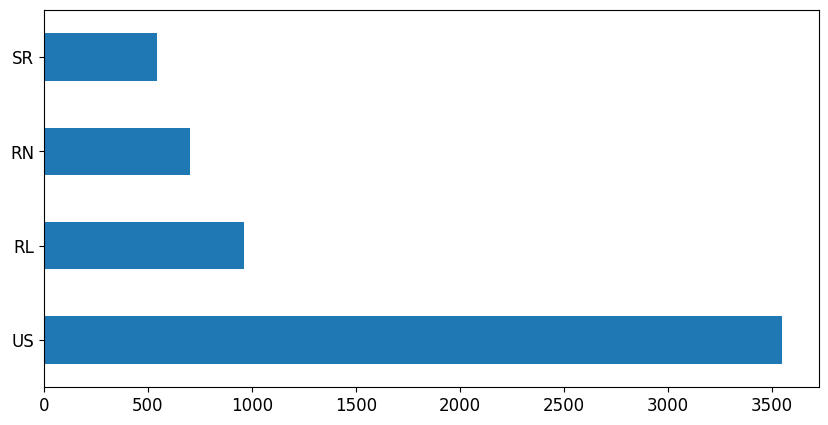

In [10]:
df["speaker"].value_counts().plot.barh()
# save_fig("speaker distribution(new).jpg")

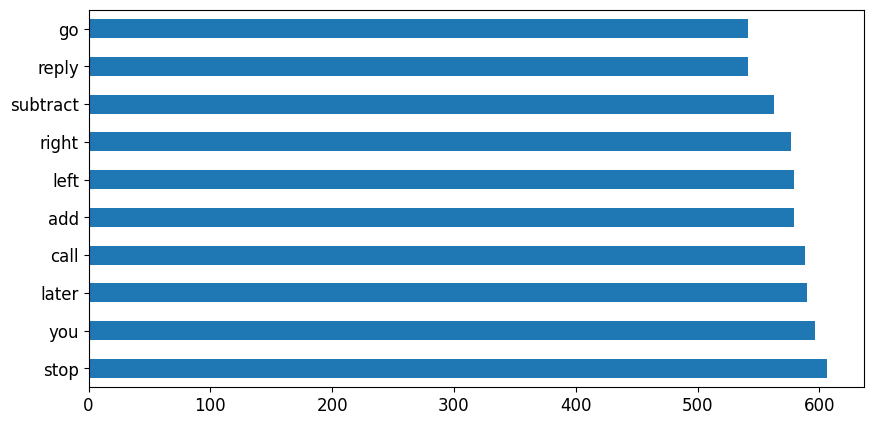

In [11]:
df["word"].value_counts().plot.barh()
# save_fig("word distribution(new).jpg")

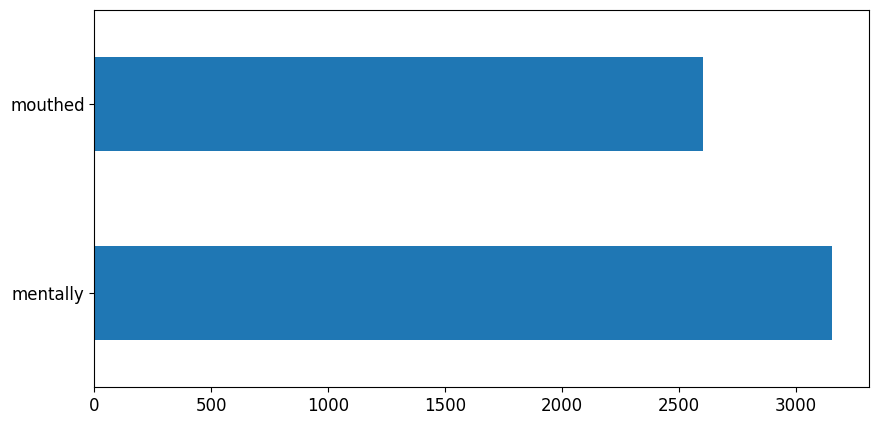

In [12]:
df["mode"].value_counts().plot.barh()
# save_fig("mode distribution(new).jpg")

In [13]:
sample = np.transpose(all_data["data"][100])
print(all_data["speaker"][100])
print(all_data["mode"][100])
print(all_data["word"][100])
print(sample.shape)

US
mentally
call
(8, 375)


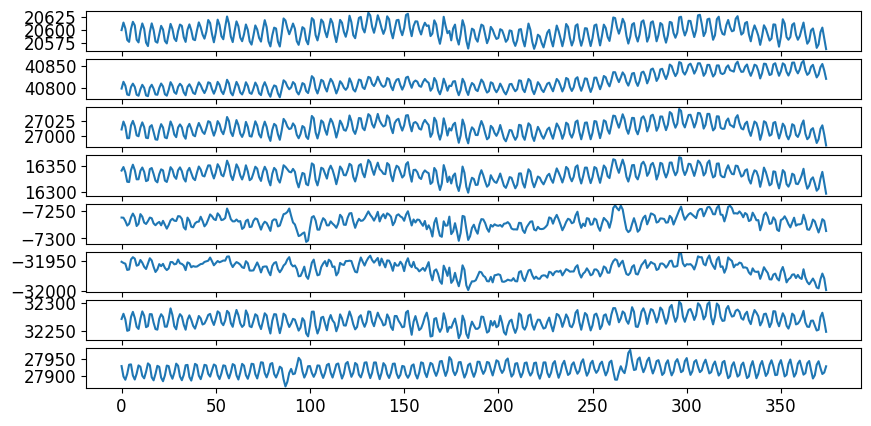

In [14]:
# plt.plot(sample[0])
# plt.plot(sample[1])
fig, axes = plt.subplots(nrows=8,ncols=1)
for i in range(8):
    axes[i].plot(sample[i])
plt.show()

In [15]:
np.mean(sample,axis=1)

array([ 20597.10122917,  40814.80858333,  27013.6815625 ,  16334.03830469,
        -7269.21934245, -31963.40845313,  32269.56521354,  27919.14928125])

In [16]:
from scipy.stats import zscore

n_sample = zscore(sample)
print(n_sample.shape)

(8, 375)


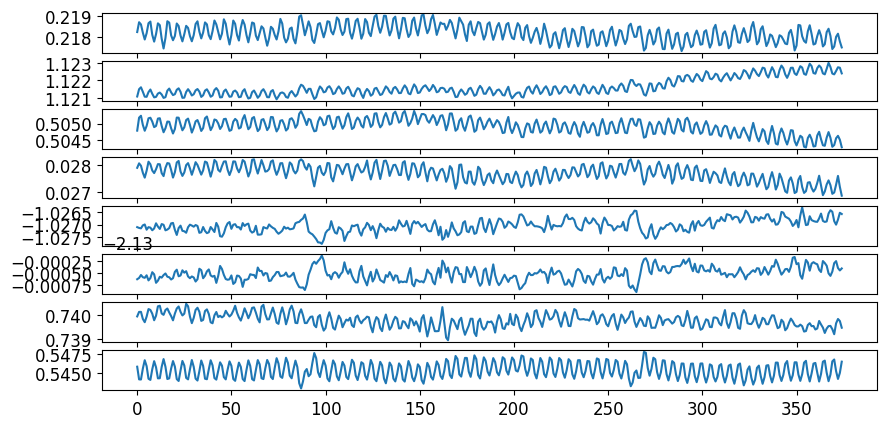

In [17]:
fig, axes = plt.subplots(nrows=8,ncols=1)
for i in range(8):
    axes[i].plot(n_sample[i])
# axes[0].set_xlabel("Samples")
plt.show()

In [18]:
df_mentally = df[df["mode"]=="mentally"]
df_mentally = df_mentally.copy().reset_index(drop=True)

df_mouthed = df[df["mode"]=="mouthed"]
df_mouthed = df_mouthed.copy().reset_index(drop=True)

In [19]:
df_call = df_mouthed[df_mouthed["word"]=="call"]

In [20]:
df_call.head(10)

,data,speaker,mode,word
0,"[[23016.1484375, 44048.71484375, 28543.6464843...",US,mouthed,call
1,"[[23077.236328125, 44117.19921875, 28587.56640...",US,mouthed,call
2,"[[23093.28515625, 44117.26953125, 28622.546875...",US,mouthed,call
3,"[[22945.7421875, 44176.41015625, 28588.1484375...",US,mouthed,call
4,"[[23031.7734375, 44162.0390625, 28598.4296875,...",US,mouthed,call
5,"[[22996.0546875, 44129.33984375, 28569.0605468...",US,mouthed,call
6,"[[23039.26171875, 44198.29296875, 28642.84375,...",US,mouthed,call
7,"[[23023.14453125, 44174.4453125, 28623.8886718...",US,mouthed,call
8,"[[23054.638671875, 44196.50390625, 28658.57812...",US,mouthed,call
9,"[[23033.337890625, 44146.01171875, 28623.0625,...",US,mouthed,call


In [21]:
df_call.tail(10)

,data,speaker,mode,word
2349,"[[40208.953125, 32049.404296875, 29378.5957031...",SR,mouthed,call
2350,"[[40337.9453125, 32257.767578125, 29474.505859...",SR,mouthed,call
2351,"[[40234.7265625, 32411.056640625, 29368.873046...",SR,mouthed,call
2352,"[[40291.65625, 32611.484375, 29425.421875, 253...",SR,mouthed,call
2353,"[[40235.015625, 32594.69921875, 29348.0859375,...",SR,mouthed,call
2354,"[[40261.83984375, 32197.552734375, 29249.29101...",SR,mouthed,call
2355,"[[40197.109375, 32234.455078125, 29180.2910156...",SR,mouthed,call
2356,"[[40144.69140625, 32174.57421875, 29096.472656...",SR,mouthed,call
2357,"[[40131.68359375, 32105.798828125, 29086.30078...",SR,mouthed,call
2358,"[[40254.953125, 32240.177734375, 29225.375, 26...",SR,mouthed,call


In [22]:
df_mentally.tail(10)

,data,speaker,mode,word
3147,"[[43238.578125, 38759.21875, 31220.244140625, ...",SR,mentally,right
3148,"[[42556.22265625, 37984.95703125, 30412.564453...",SR,mentally,right
3149,"[[43073.80078125, 38623.09765625, 31076.814453...",SR,mentally,right
3150,"[[42592.453125, 38075.66015625, 30502.61914062...",SR,mentally,right
3151,"[[42561.23046875, 38057.0625, 30486.34765625, ...",SR,mentally,right
3152,"[[42720.6640625, 38238.89453125, 30656.5332031...",SR,mentally,right
3153,"[[42696.5, 38224.12109375, 30658.92578125, 284...",SR,mentally,right
3154,"[[43033.6796875, 38608.1015625, 31007.58984375...",SR,mentally,right
3155,"[[43239.046875, 38819.6796875, 31227.509765625...",SR,mentally,right
3156,"[[42622.44921875, 38150.94140625, 30602.800781...",SR,mentally,right


In [23]:
a = df_mentally.iloc[1000]["data"]
b = df_mentally.iloc[3000]["data"]
print(df_mentally.iloc[0]["speaker"])
print(df_mentally.iloc[3000]["speaker"])
print(a.shape)
print(b.shape)

US
SR
(337, 8)
(216, 8)


<class 'list'>


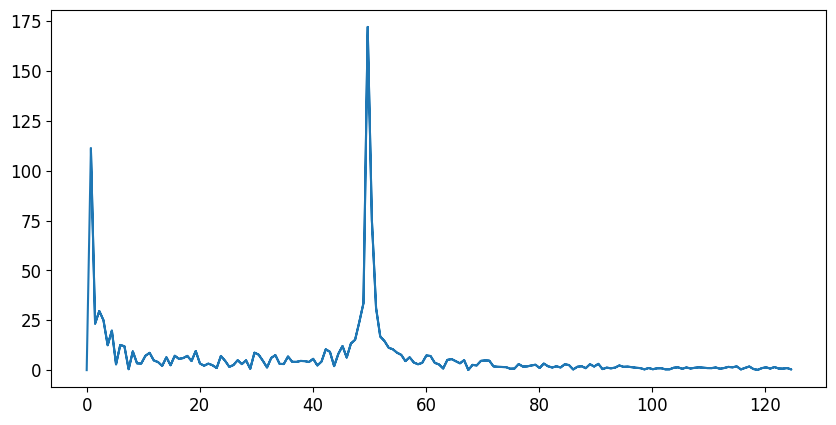

In [56]:
from scipy.fft import fft,fftfreq
from scipy.fftpack import fft
N = len(a[:,3])
y = fft(zscore(a[:,3]))
x = fftfreq(N,1/250)

N = len(b[:,3])
Y = fft(zscore(b[:,3]))
X = fftfreq(N,1/250)

# plt.plot(a[:,3])

print(type(plt.plot(abs(x),abs(y))))
# plt.scatter(abs(x),abs(y))

# plt.plot(abs(X),abs(Y))
plt.show()
# print(len(y))
# print(len(Y))
# print(len(x))
# print(len(X))


In [52]:
# r = np.corrcoef(abs(Y),abs(y))
# print(a.shape)
# print(b.shape)
# plt.plot(r[0])
# plt.show()
# print(r[0])
# print(r.shape)

108.0